In [1]:
import numpy as np
import datetime as dt
from nsepy import get_history
import lxml

In [2]:
class HMM(object):
    # Implements discrete 1-st order Hidden Markov Model 
	def __init__(self):
		pass

	def forward(self, pi, A, O, observations):
		#(Hint: see beta code. Document this properly)
        # initialization code
		N = len(observations)
		S = len(pi)
		alpha = np.zeros((N, S))
		
	    # base case alpha
		alpha[0, :] = pi * O[:,observations[0]]
		
		
	    
	    # recursive case (other alphas)
		for i in range(1, N):
			for s2 in range(S):
				for s1 in range(S):
					alpha[i, s2] += alpha[i-1, s1] * A[s1, s2] * O[s2, observations[i]]

		
		
	    
		return (alpha, np.sum(alpha[N-1,:]))

		
	def backward(self, pi, A, O, observations):
	    N = len(observations)
	    S = len(pi)
	    beta = np.zeros((N, S))
	    
	    # base case
	    beta[N-1, :] = 1
	    
	    # recursive case
	    for i in range(N-2, -1, -1):
	        for s1 in range(S):
	            for s2 in range(S):
	                beta[i, s1] += beta[i+1, s2] * A[s1, s2] * O[s2, observations[i+1]]
	    
	    return (beta, np.sum(pi * O[:, observations[0]] * beta[0,:]))


	def baum_welch(self, o, N, rand_seed=1):
	    # Implements HMM Baum-Welch algorithm        
	    M = int(max(o[0]))+1 # now all hist time-series will contain all observation vals, but we have to provide for all

	    # Initialise A, B and pi randomly, but so that they sum to one
	    np.random.seed(rand_seed)
	        
	    pi_randomizer = np.ndarray.flatten(np.random.dirichlet(np.ones(N),size=1))/100
	    pi=1.0/N*np.ones(N)-pi_randomizer

	    a_randomizer = np.random.dirichlet(np.ones(N),size=N)/100
	    a=1.0/N*np.ones([N,N])-a_randomizer

	    b_randomizer=np.random.dirichlet(np.ones(M),size=N)/100
	    b = 1.0/M*np.ones([N,M])-b_randomizer

	    pi, A, O = np.copy(pi), np.copy(a), np.copy(b) # take copies, as we modify them
	    S = pi.shape[0]
	    iterations = 1000
	    training = o
	    # do several steps of EM hill climbing
	    for it in range(iterations):
	        pi1 = np.zeros_like(pi)
	        A1 = np.zeros_like(A)
	        O1 = np.zeros_like(O)
	        
	        for observations in training:
	            # compute forward-backward matrices
	            alpha, za = self.forward(pi, A, O, observations)
	            beta, zb = self.backward(pi, A, O, observations)
	            assert abs(za - zb) < 1e-6, "it's badness 10000 if the marginals don't agree"
	            
	            # M-step here, calculating the frequency of starting state, transitions and (state, obs) pairs
	            pi1 += alpha[0,:] * beta[0,:] / za
	            for i in range(0, len(observations)):
	                O1[:, observations[i]] += alpha[i,:] * beta[i,:] / za
	            for i in range(1, len(observations)):
	                for s1 in range(S):
	                    for s2 in range(S):
	                        A1[s1, s2] += alpha[i-1,s1] * A[s1, s2] * O[s2, observations[i]] * beta[i,s2] / za
	                                                                    
	        # normalise pi1, A1, O1
	        pi = pi1 / np.sum(pi1)
	        for s in range(S):
	            A[s, :] = A1[s, :] / np.sum(A1[s, :])
	            O[s, :] = O1[s, :] / np.sum(O1[s, :])
	    return pi, A, O

	def predict(self, stock_prices, states=3):
		(pi, A, O) = self.baum_welch(np.array([stock_prices]), states)
		(alpha, c) = self.forward(pi, A, O, stock_prices)
		# normalize alpha
		row_sums = alpha.sum(axis=1)
		matrix_1 = alpha / row_sums[:, np.newaxis]
		# probability distribution of last hidden state given data
		matrix_2 = matrix_1[-1, :]
		# probability distribution of last hidden state given data
		matrix_3 = np.matmul(matrix_2, A)
		# probabilty distribution of predicted observation state given past observations
		matrix_4= np.matmul(matrix_3, O)
		return(np.argmax(matrix_4))

In [11]:
import matplotlib.pyplot as plt

In [31]:
def get_stock_prices(company_symbol, start_date, end_date):
    # stock price data from nsepy library (closing prices)
    start_date = dt.datetime.strptime(start_date, '%Y-%m-%d').date()
    end_date = dt.datetime.strptime(end_date, '%Y-%m-%d').date()
    stock_prices = get_history(symbol=company_symbol, start=start_date, end=end_date)
    print(stock_prices.index.values)
    plt.plot(stock_prices.index.values, stock_prices[stock_prices.columns[-1]])
    # pandas dataframe to numpy array
    stock_prices = stock_prices.values
    # return closing prices
    return stock_prices[:,7]

In [4]:
def get_price_movements(stock_prices):
	price_change = stock_prices[1:] - stock_prices[:-1]
	price_movement = np.array(list(map((lambda x: 1 if x>0 else 0), price_change)))
	return price_movement

[datetime.date(2019, 3, 1) datetime.date(2019, 3, 5)
 datetime.date(2019, 3, 6) datetime.date(2019, 3, 7)
 datetime.date(2019, 3, 8) datetime.date(2019, 3, 11)
 datetime.date(2019, 3, 12) datetime.date(2019, 3, 13)
 datetime.date(2019, 3, 14) datetime.date(2019, 3, 15)
 datetime.date(2019, 3, 18) datetime.date(2019, 3, 19)
 datetime.date(2019, 3, 20)]
Sell stock if you have.


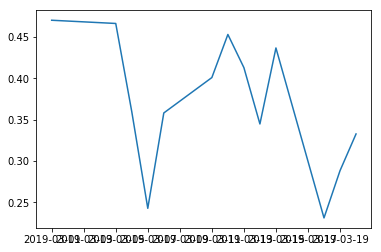

In [32]:
if __name__ == '__main__':

    hmm = HMM()
    stock_prices = get_stock_prices('SBIN', '2019-03-01', '2019-03-21')
    price_movement = get_price_movements(stock_prices)
    prediction = hmm.predict(price_movement, 5)
    if prediction==1:
    	print("You should buy stock.")
    else:
        print("Sell stock if you have.")